# Node Embeddings of Disease Graph | Stellargraph Supervised

Here, we shall have a disease graph consisting of ICD10 codes as nodes (instead of the HCC codes as nodes), and assign these nodes their HCC codes as labels. Therefore, we shall have 10k+ nodes having 83 labels. Our task shall then be supervised. This ought to help us learn better node embeddings than the unsupervised task.

NOTE: Since there can be multiple HCCs tagged for a single ICD-10 code, the task will be multi-label classification.

***Links***
* Loading data in Stellargraph objects from Pandas - https://stellargraph.readthedocs.io/en/stable/demos/basics/loading-pandas.html
* Algorithms for Task - https://stellargraph.readthedocs.io/en/v1.2.0/demos/index.html
* Node Classification with Directed GraphSAGE - https://stellargraph.readthedocs.io/en/v1.2.0/demos/node-classification/directed-graphsage-node-classification.html
* Unsupervised Representation Learning - https://stellargraph.readthedocs.io/en/stable/demos/embeddings/index.html#find-algorithms-and-demos-for-a-graph
* Unsupervised GraphSAGE & UnsupervisedSampler - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/graphsage-unsupervised-sampler-embeddings.html
* Unsupervised DeepGraphInfoMax - https://stellargraph.readthedocs.io/en/v1.2.0/demos/embeddings/deep-graph-infomax-embeddings.html
* Data Generators | Stellargraph - https://stellargraph.readthedocs.io/en/latest/api.html#stellargraph.mapper.CorruptedGenerator
* Creating multiple checkboxes in IPyWidgets - https://stackoverflow.com/questions/57219796/ipywidgets-dynamic-creation-of-checkboxes-and-selection-of-data
* 

In [2]:
# importing relevant libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual, HBox, VBox
import ipywidgets as widgets

import networkx as nx
from tensorflow import keras
from sklearn import model_selection
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from stellargraph.data import UnsupervisedSampler
from stellargraph import StellarGraph, StellarDiGraph, datasets, utils
from stellargraph.layer import GraphSAGE, DirectedGraphSAGE, link_classification, DeepGraphInfomax, GCN, GAT
from stellargraph.mapper import DirectedGraphSAGENodeGenerator, FullBatchNodeGenerator

import warnings
from time import time
from IPython.display import display, HTML
import pickle
warnings.filterwarnings('ignore')


In [3]:
# file paths
hcc_mappings_fp = "/workspaces/graphs/graphs-eda/data/metadata/2022 Midyear_Final ICD-10-CM Mappings.csv"
ip_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_preprocessed.csv"
op_data_fp = "/workspaces/graphs/graphs-eda/data/patient-data/df_outpatient.csv"
hcc_weights_fp = "../graphs-eda/data/metadata/hcc_weights_categorised.csv"


In [51]:
class ICDEmbeddingGraph:
    """
    This class contains methods, attributes and functions to 
    create the following from IP and OP data -
    1. Graph object
    2. Node features
    3. Edge features
    4. Node labels
    5. Utility functions for data exploration
    """

    def __init__(self, ip_data_fp, op_data_fp, hcc_mappings_fp):
        """Upon instantiation prepares IP and OP data for
        processing, creates nodes and edges and stores the 
        information in pandas.Dataframe objects, and prepares
        ICD-HCC-mapping table.

        Args:
            ip_data_fp (str): IP data file path
            op_data_fp (str): OP data file path
            hcc_mappings_fp (str): ICD-HCC mappings file path
        """
        self.__hcc_mappings_columns__ = [
            'Diagnosis Code', 'Description', 'CMS-HCC Model Category V24']
        self.__ip_data_columns__ = [
            'empi', 'visit_id', 'visit_start_date', 'primary_diagnosis']
        self.__op_data_columns__ = ['empi', 'visit_id',
                                    'last_date_of_service', 'primary_diagnosis']
        self.ip_data_fp = ip_data_fp
        self.op_data_fp = op_data_fp
        self.hcc_mappings_fp = hcc_mappings_fp
        self._prepare_patient_data()
        self._prepare_combined_data()
        self._create_edge_table()
        self._create_node_table()
        self._prepare_hcc_mappings()

    def _prepare_patient_data(self):
        """
        Reads and filters only the required columns from inpatient and outpatient data
        """
        start = time()
        # reading the inpatient and outpatient data
        ip_data = pd.read_csv(self.ip_data_fp)
        op_data = pd.read_csv(self.op_data_fp)

        ip_data = ip_data.loc[:, self.__ip_data_columns__]
        op_data = op_data.loc[:, self.__op_data_columns__]

        ip_data.columns = ['empi', 'vid', 'vdt', 'pd']
        op_data.columns = ['empi', 'vid', 'vdt', 'pd']

        self.ip_data = ip_data.copy()
        self.op_data = op_data.copy()
        del ip_data, op_data
        stop = time()
        print(
            f"IP and OP data prepared [Time taken: {round(stop-start, 3)} seconds]")

    def _prepare_combined_data(self):
        start = time()
        self.data = pd.concat([self.ip_data, self.op_data], axis=0)
        stop = time()
        print(
            f"IP data combined with OP data [Time taken: {round(stop-start, 3)} seconds]")

    def _create_edge_table(self, method='max'):
        """creates edge-table from data
        method can be 'jaccard' or 'sum'

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """
        start = time()
        
        data = self.data.sort_values(
            ['empi', 'vdt']).reset_index(drop=True).copy()
        data["pd_nxt"] = data.pd.shift(-1)
        index_drop = data.groupby('empi').tail(1).index
        data = data.drop(index_drop)
        # data = data[data.pd != data.pd_nxt].reset_index(drop=True)

        data['edge'] = data.pd + ", " + data.pd_nxt
        data['cnt'] = 1
        edge_data = data.groupby(
            ['pd', 'pd_nxt'], as_index=False).agg({'cnt': 'count'})
        edge_data.columns = ['source', 'target', 'weight']

        self.edge_data = edge_data.copy()
        del edge_data
        stop = time()
        print(
            f"Edge Table Created [Time taken: {round(stop-start, 3)} seconds]")

    def _create_node_table(self):
        """Creates node table from data

        Args:
            data (_type_): _description_

        Returns:
            _type_: _description_
        """
        start = time()
        node_data = pd.DataFrame(self.data.pd.unique(), columns=['pd'])
        node_data.index = node_data.pd
        node_data.pd = 1
        self.node_data = node_data.copy()
        del node_data
        stop = time()
        print(
            f"Node Table Created [Time taken: {round(stop-start, 3)} seconds]")

    def _prepare_hcc_mappings(self):
        """
        Reads, cleans and prepares the HCC metadata file
        """
        start = time()
        # reading the risk adjustment metadata file
        hcc_mappings = pd.read_csv(self.hcc_mappings_fp)

        # cleaning the risk adjustment metadata file
        hcc_mappings = hcc_mappings.iloc[2:-7, :]
        hcc_mappings.replace(r'\n', ' ', regex=True, inplace=True)
        hcc_mappings.reset_index(drop=True, inplace=True)

        # creating the cleaned risk adjustment metadata dataframe
        hcc_mappings_ = pd.DataFrame(hcc_mappings.iloc[1:, :])
        hcc_mappings_.columns = hcc_mappings.iloc[0, :].tolist()

        # filtering only the required columns from patient data and metadata
        hcc_mappings_ = hcc_mappings_.loc[:, self.__hcc_mappings_columns__]
        hcc_mappings_.columns = ['pd', 'dscr', 'hcc']
        hcc_mappings_.loc[:, "hcc"] = hcc_mappings_.hcc.fillna(0).astype('int')
        self.hcc_mappings = hcc_mappings_.query('hcc!=0')
        del hcc_mappings_
        stop = time()
        print(
            f"ICD to HCC Mappings Prepared [Time taken: {round(stop-start, 3)} seconds]")

    def remove_sparse_nodes(self, n):
        """Removes edges having weight less than n 
        and then removes nodes having no edges connected
        to them
        """
        start = time()
        self.complete_node_data, self.complete_edge_data = self.node_data.copy(), self.edge_data.copy()
        self.edge_data = self.complete_edge_data[self.complete_edge_data.weight>=n].reset_index(
            drop=True)
        filter1 = self.complete_node_data.index.isin(
            self.edge_data.source.unique())
        filter2 = self.complete_node_data.index.isin(
            self.edge_data.target.unique())
        self.node_data = self.complete_node_data[filter1 | filter2]
        stop = time()
        print(
            f"Sparse nodes removed [Time taken: {round(stop-start, 3)} seconds]")
        
        # make changes to edge weights 
        edge_max_weights = self.edge_data.groupby('source', as_index=False).aggregate({'weight':'max'})
        edge_max_weights.columns=['source','max_weight']
        self.edge_data = self.edge_data.merge(edge_max_weights, how='left')
        self.edge_data['weight'] = self.edge_data.weight/self.edge_data.max_weight
        self.edge_data.drop('max_weight', axis=1, inplace=True)

    def create_stellargraph(self):
        start = time()
        self.G = StellarDiGraph({"node": self.node_data}, {
                                "edge": self.edge_data})
        print(f"Graph created [Time taken: {round(time()-start, 3)} seconds")

    def create_node_features(self, method=None):
        """Create node features

        Args:
            node_data (_type_): _description_
            edge_data (_type_): _description_
        """
        overall_start = time()
        if method == None:
            print("Method not defined! Define one method out of \"topology\" or \"ohe\"")
            return 0
        elif method == 'topology':
            self._create_node_features_topology()
        elif method == 'ohe':
            self._create_node_features_ohe()
        elif method == 'both':
            self._create_node_features_topology()
            self._create_node_features_ohe()
        overall_stop = time()
        print(
            f"Node features created [Overall time taken: {round(overall_stop-overall_start, 3)} seconds]")

    def _create_node_features_topology(self):
        """Creates node features based on measures like degree, centrality, etc
        """
        Gd = StellarDiGraph({"node": self.node_data}, {
                            "edge": self.edge_data}).to_networkx()
        Gu = StellarGraph(self.node_data, self.edge_data).to_networkx()
        node_features_dict = {}

        node_features_dict["in_degree_centrality"] = nx.in_degree_centrality(
            Gd)
        node_features_dict["out_degree_centrality"] = nx.out_degree_centrality(
            Gd)
        node_features_dict["load_centrality"] = nx.load_centrality(Gd)
        node_features_dict["eigenvector_centrality_numpy"] = nx.eigenvector_centrality_numpy(
            Gd)
        node_features_dict["closeness_centrality"] = nx.closeness_centrality(
            Gd)
        node_features_dict["betweenness_centrality_source"] = nx.betweenness_centrality_source(
            Gd)
        node_features_dict["harmonic_centrality"] = nx.harmonic_centrality(Gd)
        node_features_dict["pagerank"] = nx.pagerank_numpy(Gd)
        node_features_dict["average_neighbor_degree"] = nx.average_neighbor_degree(
            Gd)
        node_features_dict["node_clique_number"] = nx.node_clique_number(Gu)
        node_features_dict["hits_numpy"] = nx.hits_numpy(Gd)[0]

        node_features = pd.DataFrame({'in_degree_centrality': pd.Series(
            node_features_dict['in_degree_centrality'])})
        for key, value in node_features_dict.items():
            node_features[key] = pd.Series(value)
        self.node_data = pd.concat(
            [self.node_data, node_features], axis=1).drop('pd', axis=1)
        del node_features

    def _create_node_features_ohe(self):
        """Creates OHE node features
        """
        node_data = self.node_data.copy()
        node_data.index.name = ''
        node_data['pd'] = node_data.index
        self.node_data = pd.concat(
            [self.node_data, pd.get_dummies(node_data.pd)], axis=1)
        del node_data

    def create_node_labels(self):

        start = time()
        node_labels = pd.DataFrame(self.node_data.index)
        node_labels.columns = ['pd']
        node_labels = node_labels.merge(
            self.hcc_mappings[['pd', 'hcc']], on='pd', how='left')
        node_labels = node_labels.replace({0: np.nan})
        node_labels = node_labels.dropna()
        node_labels = node_labels.fillna(0)

        node_labels_dummies_temp = pd.get_dummies(node_labels.hcc)
        aggregate_dict = dict(zip(node_labels_dummies_temp.columns, [
                              'sum'] * node_labels_dummies_temp.shape[1]))
        node_labels_dummies = pd.concat([node_labels[['pd']], node_labels_dummies_temp], axis=1).groupby(
            'pd').aggregate(aggregate_dict)
        self.node_labels = node_labels_dummies
        del node_labels_dummies
        stop = time()
        print(
            f"Node labels created [Time taken: {round(stop-start, 3)} seconds]")


In [89]:
class SupervisedHomogenousGNN(ICDEmbeddingGraph):

    def __init__(self, ip_data_fp, op_data_fp, hcc_mappings_fp):
        super().__init__(ip_data_fp, op_data_fp, hcc_mappings_fp)
        self.train_size = 0.9
        self.batch_size = 50
        self.in_samples = [7, 5]
        self.out_samples = [7, 5]
        self.layer_sizes = [32, 16]
        self.dropout = 0.5
        self.patience = 50

    def _train_test_split(self):
        start = time()
        self.train_subjects, self.test_subjects = model_selection.train_test_split(
            self.node_labels,
            train_size=self.train_size,
            # random_state=42
        )
        self.train_targets = np.array(self.train_subjects)
        self.test_targets = np.array(self.test_subjects)
        stop = time()
        print(
            f"Train:test::({round(self.train_size,2)}:{round(1-self.train_size,2)}) split done [Time taken: {round(stop-start,3)} seconds]")

    def _create_data_generator(self):
        start = time()
        self.generator = FullBatchNodeGenerator(self.G, method='gat')
        self.train_gen = self.generator.flow(
            self.train_subjects.index, self.train_targets)

        self.test_gen = self.generator.flow(
            self.test_subjects.index, self.test_targets)
        stop = time()
        print(
            f"Data generator created [Time taken: {round(stop-start,3)} seconds]")

    def _create_gnn(self):
        start = time()
        self.graphsage_model = GAT(
            layer_sizes=self.layer_sizes,
            generator=self.generator,
            bias=False,
            attn_dropout=self.dropout,
            attn_heads=8,
        )
        self.x_inp, self.x_out = self.graphsage_model.in_out_tensors()
        self.prediction = keras.layers.Dense(
            units=self.train_targets.shape[1], activation="softmax")(self.x_out)
        self.model = keras.Model(inputs=self.x_inp, outputs=self.prediction)
        self.model.compile(
            optimizer=keras.optimizers.Adam(lr=0.003),
            loss=keras.losses.categorical_crossentropy,
            metrics=["acc"],
        )
        self.es_callback = keras.callbacks.EarlyStopping(
            monitor="val_acc", patience=self.patience, restore_best_weights=True)
        stop = time()
        print(
            f"{self.graphsage_model.__class__} created [Time taken: {round(stop-start,3)} seconds]")

    def create_graph(self, threshold=5, node_feature_method='ohe'):
        # drop sparse edges, drop disconnected nodes
        self.remove_sparse_nodes(threshold)
        self.create_node_features(node_feature_method)  # create X
        self.create_node_labels()  # create y
        self.create_stellargraph()  # create G

    def create_trainer(self):
        self._train_test_split()
        self._create_data_generator()
        self._create_gnn()

    def train_gnn(self, epochs=1000):
        self.history = self.model.fit(
            self.train_gen,
            epochs=epochs,
            validation_data=self.test_gen,
            verbose=2,
            shuffle=False,
            callbacks=[self.es_callback]
        )

    def plot_history(self):
        utils.plot_history(self.history)

    def create_embeddings(self):
        start = time()
        embedding_model = keras.Model(inputs=self.x_inp, outputs=self.x_out)
        all_nodes = self.node_labels.index
        self.all_mapper = self.generator.flow(all_nodes)
        embeddings = embedding_model.predict(self.all_mapper)[0]
        self.embeddings_icd = pd.DataFrame(embeddings, index=self.node_labels.index, columns=[f"X{i}" for i in np.arange(embeddings.shape[1])])
        self.embeddings_hcc = self.embeddings_icd.reset_index().merge(self.hcc_mappings[['hcc','pd']], how='left').groupby('hcc').agg('median')

        stop = time()
        print(
            f"Embeddings extracted [Time taken: {round(stop-start,3)} seconds]")

        start = time()
        self.transform = TSNE(n_components=2)  # dimensionality reduction
        self.emb_tsne = pd.DataFrame(self.transform.fit_transform(
            self.embeddings_icd), index=self.node_labels.index)
        self.emb_tsne.index.name = ''
        self.emb_tsne['pd'] = self.emb_tsne.index
        self.emb_tsne = self.emb_tsne.merge(
            self.hcc_mappings[['pd', 'hcc']], on='pd', how='left')
        stop = time()
        print(
            f"TSNE embeddings created [Time taken: {round(stop-start,3)} seconds]")

    def select_hccs(self):
        self.hccs = self.emb_tsne.hcc.sort_values().unique().tolist()
        self.checkboxes = [widgets.Checkbox(
            value=False, description=str(hcc)) for hcc in self.hccs]
        self.output = widgets.VBox(children=self.checkboxes)
        n = len(self.checkboxes)//6
        return HBox([
            VBox(self.checkboxes[:n]),
            VBox(self.checkboxes[n:2*n]),
            VBox(self.checkboxes[2*n:3*n]),
            VBox(self.checkboxes[3*n:4*n]),
            VBox(self.checkboxes[4*n:5*n]),
            VBox(self.checkboxes[5*n:])
        ])

    def plot_embeddings(self):
        selected_data = []
        for i in range(0, len(self.checkboxes)):
            if self.checkboxes[i].value == True:
                selected_data = selected_data + \
                    [self.checkboxes[i].description]
        selected_data = [float(i) for i in selected_data]
        alpha = 0.7

        fig, ax = plt.subplots(figsize=(18, 18))
        ax.scatter(
            self.emb_tsne[0],
            self.emb_tsne[1],
            alpha=alpha,
        )
        ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
        plt.title(
            "TSNE ICD-10 Disease Embeddings Supervised GAT with Node Features")
        selected_data_embeddings = self.emb_tsne[self.emb_tsne.hcc.isin(
            selected_data)]
        for i, row in selected_data_embeddings.iterrows():
            plt.annotate(row['hcc'], (row[0], row[1]))
            ax.scatter(
                row[0],
                row[1],
                c='red',
                s=80,
                alpha=alpha,
            )
        plt.show()


In [90]:
del trainer

In [91]:
trainer = SupervisedHomogenousGNN(
    ip_data_fp, op_data_fp, hcc_mappings_fp)

IP and OP data prepared [Time taken: 2.262 seconds]
IP data combined with OP data [Time taken: 0.014 seconds]
Edge Table Created [Time taken: 0.536 seconds]
Node Table Created [Time taken: 0.024 seconds]
ICD to HCC Mappings Prepared [Time taken: 0.298 seconds]


In [92]:
trainer.create_graph(2, 'ohe')

Sparse nodes removed [Time taken: 0.033 seconds]
Node features created [Overall time taken: 0.162 seconds]
Node labels created [Time taken: 0.111 seconds]
Graph created [Time taken: 0.186 seconds


In [93]:
print(trainer.G.info())

StellarDiGraph: Directed multigraph
 Nodes: 3470, Edges: 22944

 Node types:
  node: [3470]
    Features: float32 vector, length 3471
    Edge types: node-edge->node

 Edge types:
    node-edge->node: [22944]
        Weights: range=[5.2017e-05, 1], mean=0.196426, std=0.356658
        Features: none


In [94]:
trainer.create_trainer()

Train:test::(0.9:0.1) split done [Time taken: 0.006 seconds]
Data generator created [Time taken: 0.011 seconds]
<class 'stellargraph.layer.graph_attention.GAT'> created [Time taken: 0.645 seconds]


In [95]:
trainer.train_gnn()

Epoch 1/1000
1/1 - 4s - loss: 4.4423 - acc: 0.0144 - val_loss: 4.3605 - val_acc: 0.0887
Epoch 2/1000
1/1 - 1s - loss: 4.4119 - acc: 0.1569 - val_loss: 4.3403 - val_acc: 0.1048
Epoch 3/1000
1/1 - 1s - loss: 4.3813 - acc: 0.1966 - val_loss: 4.3191 - val_acc: 0.0968
Epoch 4/1000
1/1 - 1s - loss: 4.3496 - acc: 0.2011 - val_loss: 4.2963 - val_acc: 0.0968
Epoch 5/1000
1/1 - 1s - loss: 4.3161 - acc: 0.2002 - val_loss: 4.2714 - val_acc: 0.0968
Epoch 6/1000
1/1 - 1s - loss: 4.2804 - acc: 0.2020 - val_loss: 4.2441 - val_acc: 0.1048
Epoch 7/1000
1/1 - 1s - loss: 4.2422 - acc: 0.2038 - val_loss: 4.2144 - val_acc: 0.1048
Epoch 8/1000
1/1 - 1s - loss: 4.2014 - acc: 0.2020 - val_loss: 4.1820 - val_acc: 0.1048
Epoch 9/1000
1/1 - 1s - loss: 4.1579 - acc: 0.2020 - val_loss: 4.1472 - val_acc: 0.1048
Epoch 10/1000
1/1 - 1s - loss: 4.1119 - acc: 0.1993 - val_loss: 4.1100 - val_acc: 0.1048
Epoch 11/1000
1/1 - 1s - loss: 4.0635 - acc: 0.2011 - val_loss: 4.0709 - val_acc: 0.1129
Epoch 12/1000
1/1 - 1s - loss:

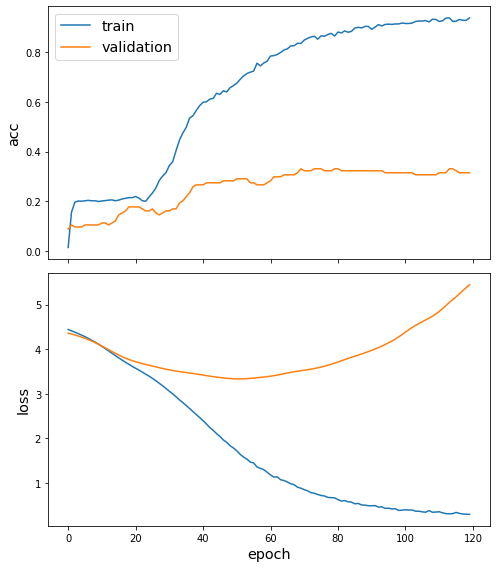

In [96]:
trainer.plot_history()

In [97]:
trainer.create_embeddings()

Embeddings extracted [Time taken: 0.533 seconds]
TSNE embeddings created [Time taken: 5.906 seconds]


In [106]:
trainer.select_hccs()  # do not run cell after the checkboxes are displayed

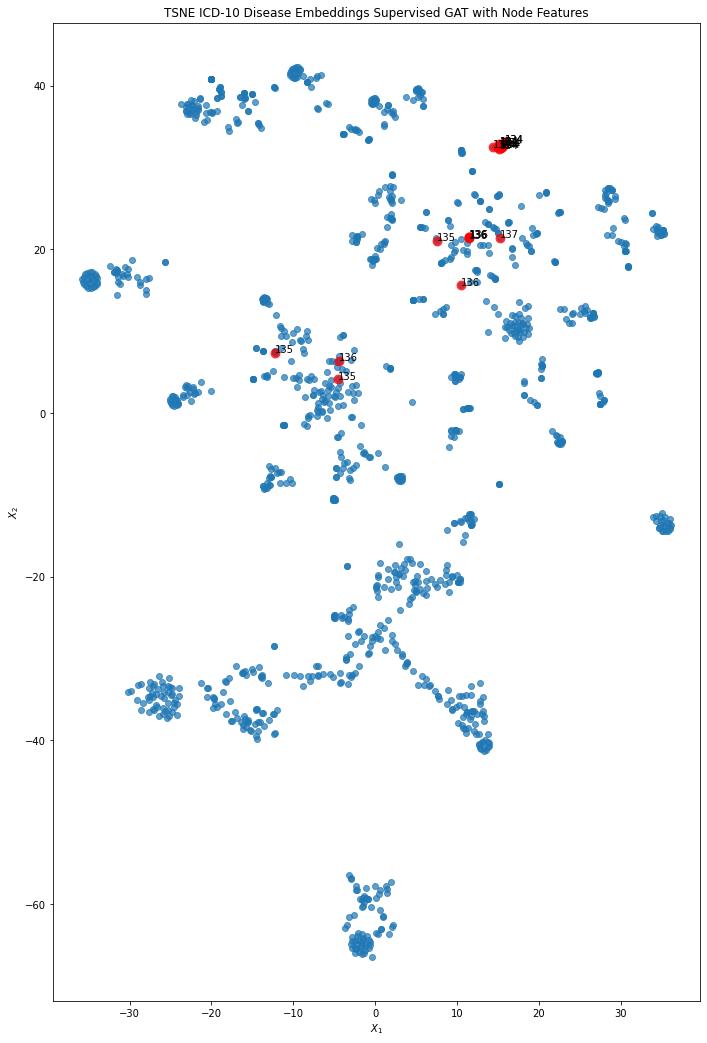

In [110]:
trainer.plot_embeddings()

In [111]:
class SuspectCodes:
    
    
    def __init__(self, graph_trainer, hcc_weights_fp):
        self.graph_trainer = graph_trainer
        self._prepare_icd_embeddings()
        self._prepare_metadata(hcc_weights_fp)

    def _prepare_icd_embeddings(self):
        start = time()
        emb_icd = self.graph_trainer.embeddings_icd.copy()
        emb_icd.index.name = 'pd'
        emb_icd.reset_index(inplace=True)
        self.icd_embeddings = emb_icd.merge(self.graph_trainer.hcc_mappings[['pd','hcc']], on='pd', how='left')
        self.icd_embeddings = self.icd_embeddings.groupby('pd').head(1).reset_index(drop=True)
        # self.icd_embeddings = pd.concat([emb_icd[['pd','hcc']], emb_icd.iloc[:,1:]], axis=1)
        del emb_icd
        stop = time()
        print(f"ICD Embeddings prepared [Time taken: {round(stop-start,3)} seconds]")

    def _prepare_metadata(self, hcc_weights_fp):
        start = time()
        self.hcc_weights = pd.read_csv(hcc_weights_fp)
        self.patient_data = self.graph_trainer.data.merge(self.graph_trainer.hcc_mappings, how='left').replace(0,np.nan).dropna()
        self.filtered_hcc_mappings = self.graph_trainer.hcc_mappings[self.graph_trainer.hcc_mappings.pd.isin(self.graph_trainer.emb_tsne.pd.unique())]
        self.empis =  self.patient_data.empi.unique()
        print(f"Metadata prepared [Time taken: {round(time()-start,3)} seconds]")

    def _compute_icd_similarities(self):
        emb_icds = self.icd_embeddings.groupby('pd').head(1).reset_index(drop=True)
        emb_icds.index = emb_icds.pd
        emb_icds.drop(['pd','hcc'], axis=1, inplace=True)
        self.similarity_icds = emb_icds.T.corr()

    def compute_modal_hccs(self, empi, k=10):

        filtered_hcc_mappings = self.graph_trainer.hcc_mappings[self.graph_trainer.hcc_mappings.pd.isin(self.graph_trainer.emb_tsne.pd.unique())]
        empi_data = self.patient_data[self.patient_data.empi==empi]
        self.existing_icds = empi_data.sort_values('hcc').pd.unique().tolist()
        self.existing_hccs = empi_data.hcc.astype(int).sort_values().unique().tolist()

        # compute similarity scores
        self._compute_icd_similarities()

        # compute modal hcc for each icd in patient's history
        self.modal_hccs = []
        for icd in self.existing_icds:
            if icd in self.similarity_icds.index:
                top_k_similar_icds = self.similarity_icds[icd].sort_values()[-(k+1):-1].index
                modal_hcc = self.filtered_hcc_mappings[self.filtered_hcc_mappings.pd.isin(top_k_similar_icds)].hcc.mode().values[0]
                hcc = self.filtered_hcc_mappings[self.filtered_hcc_mappings.pd==icd].hcc.values
                print(f"Modal HCC for {icd} (HCC-{hcc})= {modal_hcc}")
                self.modal_hccs.append(modal_hcc)

        self.modal_hccs = list(set(self.modal_hccs))
        self.suspect_hccs = list(set(self.modal_hccs) - set(self.existing_hccs))
        # remove suspect hccs that are lower down the heirarchy
        for hcc in self.suspect_hccs:
            if self.hcc_weights[self.hcc_weights.hcc==hcc].shape[0]>0:
                cat = self.hcc_weights[self.hcc_weights.hcc==hcc].cat.values[0]
                weight = self.hcc_weights[self.hcc_weights.hcc==hcc].weight.values[0]
                filter1 = self.hcc_weights.cat==cat
                filter2 = self.hcc_weights.hcc.isin(self.existing_hccs)
                if self.hcc_weights[filter1 & filter2].weight.max() > weight:
                    self.suspect_hccs.remove(hcc)
            
        print(
            f"""
            EMPI = {empi}
                Existing HCCs = {self.existing_hccs}
                Suspect HCCs  = {self.suspect_hccs}
            """)
        self.plot_suspect_graph()

    def compute_modal_hccs_minus_existing(self, empi, k=10, threshold=0):
        
        self.preprocess_top_k_nearest_neighbours(empi)
        
        # compute modal hcc for each icd in patient's history
        self.modal_hccs = []
        for icd in self.existing_icds:
            
            self.hcc = self.graph_trainer.hcc_mappings.query(f"pd=='{icd}'").hcc.values[0]
            
            if icd in self.similarity_icds.index:

                modal_hcc = self.top_k_nearest_nodes(icd, k)
                """
                Below - code to check if modal HCC's correlation with the icd is above 
                the threshold as defined by the user. Default threshold value = 0
                """
                emb_i = self.icd_embeddings.query(f"pd=='{icd}'")
                emb_i.index = emb_i.pd
                emb_i.drop(['pd','hcc'], axis= 1, inplace=True)

                emb_hccs = self.icd_embeddings.groupby('hcc').agg('median')
                hcc_corr = pd.concat([emb_hccs, emb_i], axis=0).T.corr()[icd][modal_hcc]
                print(f"Modal HCC for {icd} (HCC-{self.hcc})= {modal_hcc} [Similarity (corr): {round(hcc_corr,3)}]")
                if hcc_corr > threshold:
                    self.modal_hccs.append(modal_hcc)

        self.modal_hccs = list(set(self.modal_hccs))
        self.suspect_hccs = list(set(self.modal_hccs) - set(self.existing_hccs))
        # remove suspect hccs that are lower down the heirarchy
        for hcc in self.suspect_hccs:
            if self.hcc_weights[self.hcc_weights.hcc==hcc].shape[0]>0:
                cat = self.hcc_weights[self.hcc_weights.hcc==hcc].cat.values[0]
                weight = self.hcc_weights[self.hcc_weights.hcc==hcc].weight.values[0]
                filter1 = self.hcc_weights.cat==cat
                filter2 = self.hcc_weights.hcc.isin(self.existing_hccs)
                if self.hcc_weights[filter1 & filter2].weight.max() > weight:
                    self.suspect_hccs.remove(hcc)
            
        print(
            f"""
            EMPI = {empi}
                Existing HCCs = {self.existing_hccs}
                Suspect HCCs  = {self.suspect_hccs}
            """)
        self.plot_suspect_graph()

    def preprocess_top_k_nearest_neighbours(self, empi):
        empi_data = self.patient_data[self.patient_data.empi==empi]
        self.existing_icds = empi_data.sort_values('hcc').pd.unique().tolist()
        self.existing_hccs = empi_data.hcc.astype(int).sort_values().unique().tolist()

        self.filter_icds = self.icd_embeddings.query(f"hcc not in {tuple(self.existing_hccs)}").pd
        self.emb_icd_filtered = self.icd_embeddings[self.icd_embeddings.pd.isin(self.filter_icds)]

        # compute similarity scores
        self._compute_icd_similarities()

    def top_k_nearest_nodes(self, icd, k, print_correlations=False):
        """
        Helper function for `compute_modal_hccs_minus_existing` function.
        NOTE: This function can be used independently to print the top k
        nodes to a given icd along with their similarities, without 
        filtering out nodes corresponding to existing hccs
        """
        emb_i = self.icd_embeddings.query(f"pd == '{icd}'")
        emb_i_icd_filtered = pd.concat([self.emb_icd_filtered,emb_i], axis=0)
        emb_i_icd_filtered.index=emb_i_icd_filtered.pd
        emb_i_icd_filtered.drop(['pd'], axis=1, inplace=True)

        top_k_similar_icds = emb_i_icd_filtered.drop(['hcc'], axis=1).T.corr()[icd].drop(icd).sort_values()
        top_k_similar_icds = top_k_similar_icds.reset_index().merge(trainer.hcc_mappings)
        modal_hcc = top_k_similar_icds.tail(k).hcc.mode().values[0]
        
        if print_correlations==True:
            return top_k_similar_icds
        else:
            return modal_hcc

    def print_top_k_neighbours(self, empi, icd, k):
        empi_data = self.patient_data[self.patient_data.empi==empi]
        self.existing_icds = empi_data.sort_values('hcc').pd.unique().tolist()
        self.existing_hccs = empi_data.hcc.astype(int).sort_values().unique().tolist()
        self.filter_icds = self.icd_embeddings.query(f"hcc not in {tuple(self.existing_hccs)}").pd
        self.emb_icd_filtered = self.icd_embeddings[self.icd_embeddings.pd.isin(self.filter_icds)]

        return self.top_k_nearest_nodes(icd, k, True)

    def plot_suspect_graph(self):

        suspect_hcc_embeddings = self.graph_trainer.emb_tsne[self.graph_trainer.emb_tsne.hcc.isin(self.suspect_hccs)]
        existing_icd_embeddings = self.graph_trainer.emb_tsne[self.graph_trainer.emb_tsne.pd.isin(self.existing_icds)]
        existing_hcc_embeddings = self.graph_trainer.emb_tsne[self.graph_trainer.emb_tsne.hcc.isin(self.existing_hccs)]
        aggregate_hccs = self.graph_trainer.emb_tsne.groupby(
            'hcc').aggregate({0: 'median', 1: 'median'})        
        
        fig, ax = plt.subplots(figsize=(14, 14))
        plt.title("TSNE ICD-10 Disease Embeddings Supervised GAT with Node Features")
        ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")

        ax.scatter(
            self.graph_trainer.emb_tsne[0],
            self.graph_trainer.emb_tsne[1],
            alpha=0.2,
            c='slategray'
        )

        # for i, row in existing_hcc_embeddings.iterrows():
        ax.scatter(
            existing_hcc_embeddings[0],existing_hcc_embeddings[1],
            c='royalblue',marker='o',
            s=80, alpha=0.8,
            label='Existing HCC'
        )
        # for i, row in suspect_hcc_embeddings.iterrows():
        ax.scatter(
            suspect_hcc_embeddings[0],suspect_hcc_embeddings[1],
            c='tomato',marker='o',
            s=120, alpha=0.9,
            label='Suspect HCC'
        )
        for i, row in existing_icd_embeddings.iterrows():
            plt.annotate(f"{row['pd']} (HCC-{row['hcc']})", (row[0],row[1]))
        ax.scatter(
            existing_icd_embeddings[0],existing_icd_embeddings[1],
            c='black',marker='o',
            s=150, alpha=0.95,
            label='Existing-PD'
        )

        for hcc, coordinates in aggregate_hccs.iterrows():
            if hcc in self.existing_hccs:
                plt.annotate(f"HCC-{hcc}", (coordinates[0], coordinates[1]), fontsize=15, c='midnightblue', fontweight=100)
        for hcc, coordinates in aggregate_hccs.iterrows():
            if hcc in self.suspect_hccs:
                plt.annotate(f"HCC-{hcc}", (coordinates[0], coordinates[1]), fontsize=15, c='darkred')
        plt.legend()
        plt.show()
        pass

In [112]:
suspect_obj = SuspectCodes(trainer, hcc_weights_fp)
empis = suspect_obj.empis

ICD Embeddings prepared [Time taken: 0.028 seconds]
Metadata prepared [Time taken: 0.578 seconds]


In [114]:
suspect_obj.print_top_k_neighbours(empis[118], 'C719', 10).tail(10)

,pd,C719,dscr,hcc
979,C772,0.887132,Secondary and unspecified malignant neoplasm o...,8
980,C7B8,0.894230,Other secondary neuroendocrine tumors,8
981,C051,0.902231,Malignant neoplasm of soft palate,11
982,C799,0.902424,Secondary malignant neoplasm of unspecified site,8
983,C7800,0.906089,Secondary malignant neoplasm of unspecified lung,8
984,C7802,0.913453,Secondary malignant neoplasm of left lung,8
985,D709,0.917957,"Neutropenia, unspecified",47
986,C7B02,0.921661,Secondary carcinoid tumors of liver,8
987,C770,0.943571,Secondary and unspecified malignant neoplasm o...,8
988,C7889,0.965086,Secondary malignant neoplasm of other digestiv...,8


In [115]:
# checked_empis = [*33, 50, 55*, 63, 73, *75*, 76, 79, *85, 86, 87*, 
# 88, 91, 98, *99, *104*, 108*, 110, 117, *118, 124, 131*
# ]

Modal HCC for I4891 (HCC-96)= 86 [Similarity (corr): 0.692]
Modal HCC for M4854XA (HCC-169)= 112 [Similarity (corr): 0.51]

            EMPI = M0339032486
                Existing HCCs = [96, 169]
                Suspect HCCs  = []
            


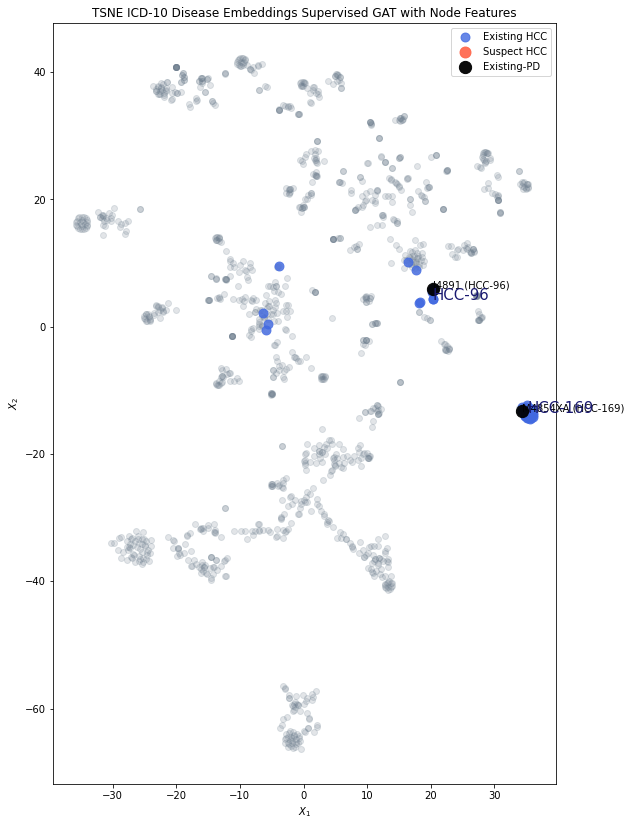

In [169]:
suspect_obj.compute_modal_hccs_minus_existing(empis[172], 10, 0.75)

Modal HCC for A419 (HCC-[2])= 2
Modal HCC for J9601 (HCC-[84])= 85
Modal HCC for J449 (HCC-[111])= 111
Modal HCC for J441 (HCC-[111])= 84
Modal HCC for J181 (HCC-[115])= 2

            EMPI = M0184710539
                Existing HCCs = [2, 84, 111, 115]
                Suspect HCCs  = [85]
            


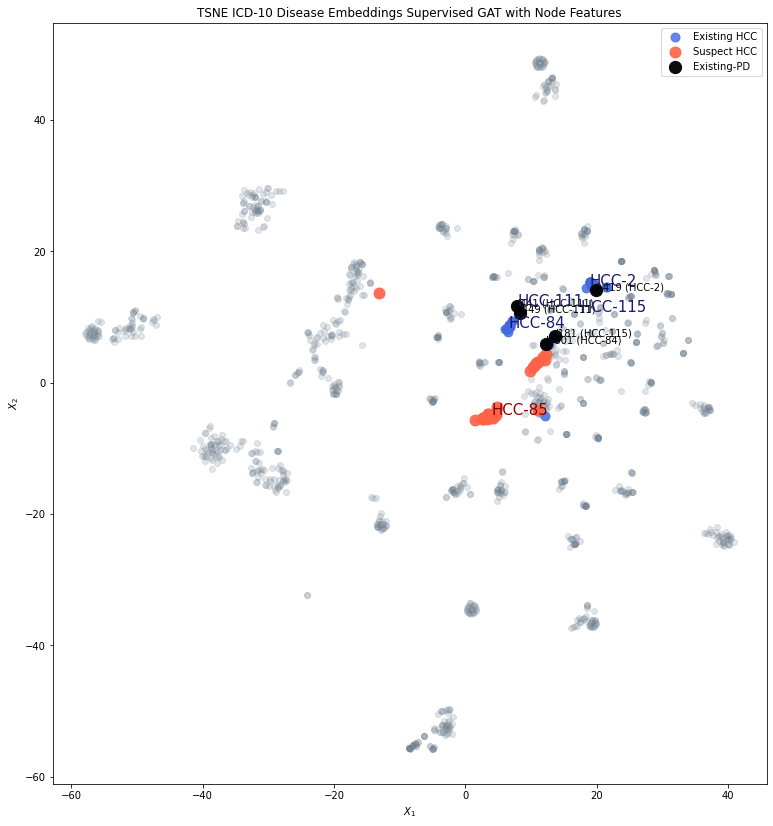

In [19]:
suspect_obj.compute_modal_hccs(suspect_obj.empis[99], 10)

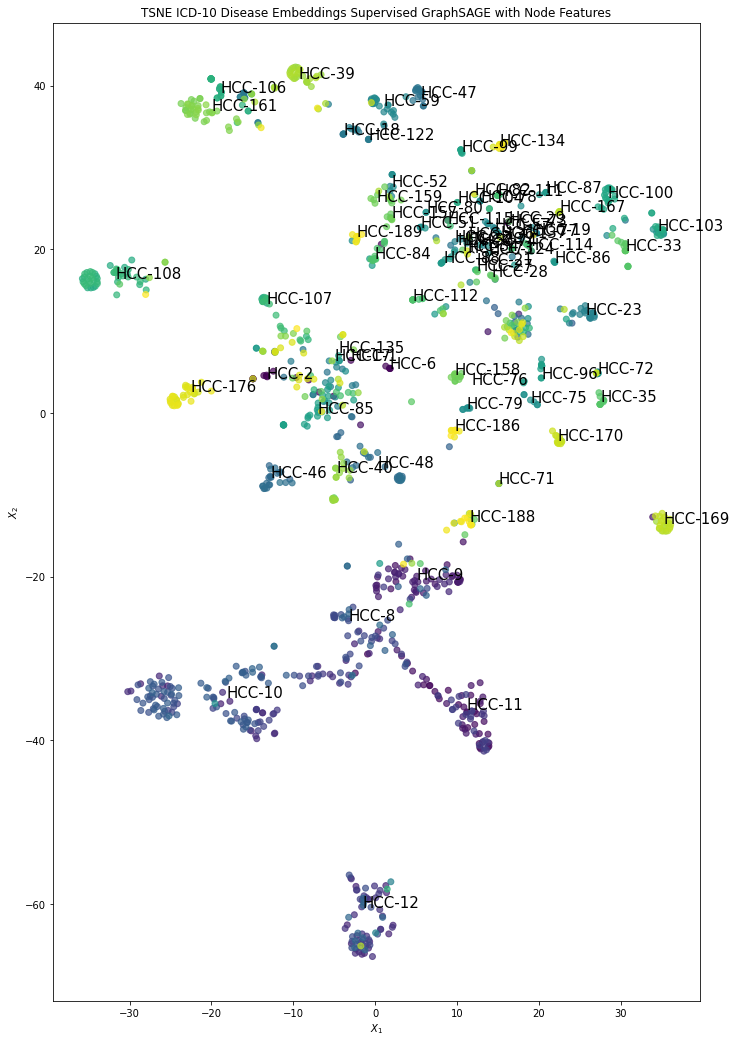

In [125]:
selected_data = []
for i in range(0, len(trainer.checkboxes)):
    if trainer.checkboxes[i].value == True:
        selected_data = selected_data + [trainer.checkboxes[i].description]
selected_data = [float(i) for i in selected_data]
alpha = 0.7

fig, ax = plt.subplots(figsize=(18, 18))
ax.scatter(
    trainer.emb_tsne[0],
    trainer.emb_tsne[1],
    alpha=alpha,
    c=np.arange(trainer.emb_tsne.shape[0])
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("TSNE ICD-10 Disease Embeddings Supervised GraphSAGE with Node Features")
aggregate_hccs = trainer.emb_tsne.groupby(
    'hcc').aggregate({0: 'median', 1: 'median'})
for hcc, coordinates in aggregate_hccs.iterrows():
    plt.annotate(f"HCC-{hcc}", (coordinates[0], coordinates[1]), fontsize=15)
plt.show()


In [ ]:
"""
Working Logic -
    - For a pd in an empi, compute the k nearest icds (cosine similarity)
    - For these k nearest icds, take the mode of the HCC corresponding to these icds (i.e the most commonly occuring hcc in the vicinity of the icd)
    - Do this for all the pds for the empi to obtain multiple modal HCC corresponding to these pds
    - Filter the modal HCCs as per the following rules -
        1. remove HCCs that have already been reported in the past
        2. remove HCCs that occur down the heirarchy, if an HCC up the heirarchy has been reported in the past 
            (eg. if HCC 17 has been reported, and HCC 18 has been reported as a modal HCC, then remove HCC 18)
    - The remaining modal HCCs after filteration are the suspect HCCs

Optimisation - 
    - optimise the model so that it gives lower false positives by hypertuning the value of k neighbours
"""


In [16]:
"""
[I.]
    Single Clusters - 
    8, 9, 10, 11, 12
    46, 47, 48
    167, 188

    Single Clusters with Outliers - 
    96, 108, 

    Single Clusters with Single Overlap - 
    23, 169

    Single Clusters with Multiple Overlaps - 
    186
    (134, 176)

[II.]
    Pairs with a few Extreme Outliers
    (27, 28)

    Close Pairs with Overlaps
    (19, 135)
    (85, 115)
    (77, 79)
    (103, 104)
    (106, 189)

[III.]
    Multiple Clusters with Overlaps
    (52, 57, 58, 59) (51 also with outliers)

    Multiple Clusters with Outliers
    (111, 112, 114)

[IV.]
    Sparse HCCs -
    1, 72, 73, 173
"""


'\n[I.]\n    Single Clusters - \n    8, 9, 10, 11, 12\n    46, 47, 48\n    167, 188\n\n    Single Clusters with Outliers - \n    96, 108, \n\n    Single Clusters with Single Overlap - \n    23, 169\n\n    Single Clusters with Multiple Overlaps - \n    186\n    (134, 176)\n    (0, 18, 189)\n\n[II.]\n    Pairs with a few Extreme Outliers\n    (27, 28)\n\n    Close Pairs with Overlaps\n    (19, 135)\n    (85, 115)\n    (77, 79)\n    (103, 104)\n\n[III.]\n    Multiple Clusters with Overlaps\n    (52, 57, 58, 59) (51 also with outliers)\n\n    Multiple Clusters with Outliers\n    (111, 112, 114)\n\n[IV.]\n    Sparse HCCs -\n    1, 72, 73, 173\n'